# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data. 

Plan for this tutorial:

1. Loading the data
2. Training the scLVM to learn a basis of gene expression on the scRNA-seq data
3. Training the stLVM to perform the deconvolution
4. Visualize the learned cell type proportions
5. Dig into the intra cell type information 

In [1]:
import sys

#if True, will install via pypi, else will install from source
stable = False
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 61kB 7.7MB/s  eta 0:00:01
ERROR: nbclient 0.5.3 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 839kB 20.2MB/s 
     |████████████████████████████████| 634kB 55.4MB/s 
     |████████████████████████████████| 122kB 60.0MB/s 
     |████████████████████████████████| 204kB 52.8MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 245kB 57.0MB/s 
     |████████████████████████████████| 10.3MB 29.2MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 3.2MB 46.5MB/s 
     |████████████████████████████████| 2.4MB 46.2MB/s 
     |████████████████████████████████| 8.7MB 166kB/s 
     |████████████████████████████████| 276kB 55.0MB/s 
     |████████████

Let's download our data from a comparative study of murine lymph nodes, comparing wild-type with a stimulation after injection of a mycobacteria. We have at disposal a 10x Visium dataset as well as a matching scRNA-seq dataset from the same tissue.

In [2]:
!wget --quiet https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/ST-LN-compressed.h5ad?raw=true -O ST-LN-compressed.h5ad
!wget --quiet https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/scRNA-LN-compressed.h5ad?raw=true -O scRNA-LN-compressed.h5ad

In [3]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import umap

import scvi
from scvi.model import CondSCVI, DestVI

import torch

%matplotlib inline

## Data processing

First, let's load the single-cell data

In [4]:
sc_adata = sc.read_h5ad("scRNA-LN-compressed.h5ad")

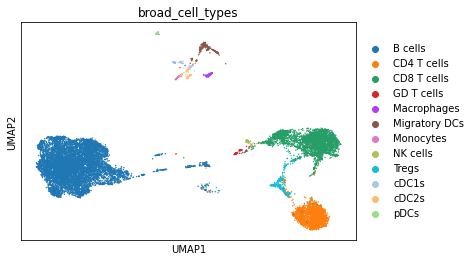

In [ ]:
sc.pl.umap(sc_adata, color="broad_cell_types")

In [ ]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Now, let's load the spatial data and choose a common gene subset

In [ ]:
st_adata = sc.read_h5ad("ST-LN-compressed.h5ad")

In [ ]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [ ]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

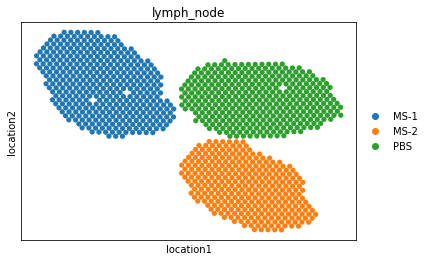

In [ ]:
sc.pl.embedding(st_adata, basis="location", color="lymph_node")

## Fit the scLVM

In [ ]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["broad_cell_types"]                                     
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14989 cells, 1888 vars, 1 batches,
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


Here we would like to reweight each measurement by a scalar factor (e.g., the inverse proportion) in the loss of the model so that lowly abundant cell types get better fit by the model.

In [ ]:
sc_model = CondSCVI(sc_adata, weight_obs=True)

In [ ]:
sc_model.train(max_epochs=250)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s, loss=6.32e+03, v_num=1]


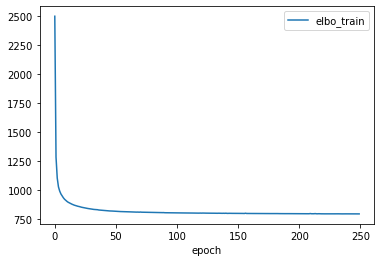

In [ ]:
sc_model.history["elbo_train"].plot()

## Deconvolution with stLVM

In [ ]:
scvi.data.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1092 cells, 1888 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [ ]:
st_model = DestVI.from_rna_model(st_adata, sc_model)

In [ ]:
st_model.train(max_epochs=2500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|██████████| 2500/2500 [04:33<00:00,  9.15it/s, loss=1.91e+06, v_num=1]


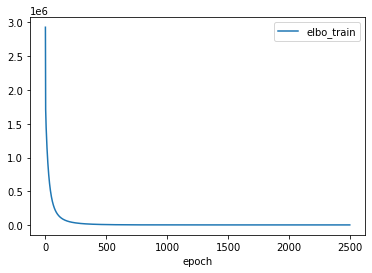

In [ ]:
st_model.history["elbo_train"].plot()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot. 

## Cell type proportions


In [ ]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [ ]:
st_adata.obsm["proportions"]

,B cells,CD4 T cells,CD8 T cells,GD T cells,Macrophages,Migratory DCs,Monocytes,NK cells,Tregs,cDC1s,cDC2s,pDCs
AAACCGGGTAGGTACC-1-0,0.633826,0.007754,0.128811,0.002299,0.078603,0.033299,0.021271,0.004697,0.015033,0.031073,0.013144,0.030190
AAACCTCATGAAGTTG-1-0,0.641194,0.100109,0.007951,0.005722,0.009229,0.081148,0.000269,0.000459,0.017668,0.046709,0.052575,0.036968
AAAGACTGGGCGCTTT-1-0,0.482154,0.076737,0.113504,0.002539,0.001495,0.123023,0.000288,0.030822,0.004888,0.005079,0.132357,0.027113
AAAGGGCAGCTTGAAT-1-0,0.016148,0.068149,0.462433,0.018014,0.066133,0.123824,0.019266,0.036453,0.119627,0.067232,0.001609,0.001111
AAAGTCGACCCTCAGT-1-0,0.887101,0.014011,0.003001,0.000484,0.002278,0.000485,0.001928,0.000229,0.008134,0.003371,0.074247,0.004729
...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTCACACTCGTAA-1-1,0.213197,0.017732,0.384616,0.066262,0.072417,0.070763,0.001806,0.011041,0.044025,0.005903,0.090101,0.022138
TTGTAAGGCCAGTTGG-1-1,0.296767,0.064163,0.065226,0.079525,0.095162,0.176777,0.032021,0.028076,0.001819,0.062209,0.008209,0.090046
TTGTAATCCGTACTCG-1-1,0.552921,0.055909,0.006217,0.027947,0.026906,0.086633,0.000514,0.012483,0.071233,0.063834,0.093342,0.002060
TTGTATCACACAGAAT-1-1,0.202562,0.024752,0.182178,0.072023,0.001748,0.268095,0.026308,0.002946,0.139291,0.011848,0.055199,0.013050


In [ ]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
  data = st_adata.obsm["proportions"][ct].values
  st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

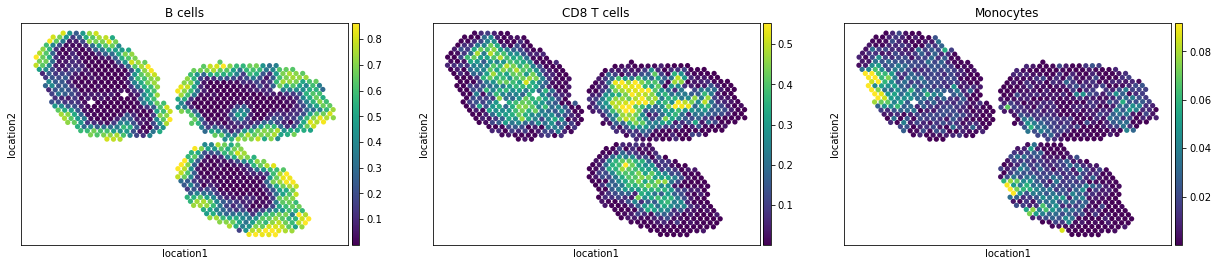

In [ ]:
sc.pl.embedding(st_adata, basis="location", color=ct_list)

We observe a strong compartimentalization of the cell types in the lymph node (B cells / T cells), as expected. We also observe a differential localization of the monocytes (refer to the paper for further details).

## Intra cell type information

At the heart of DestVI is a multitude of latent variables (5 per cell type per spots). We refer to them as "gamma", and we may manually examine them for downstream analysis

In [ ]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
  st_adata.obsm["{}_gamma".format(ct)] = g

In [ ]:
st_adata.obsm["B cells_gamma"].head(5)

,0,1,2,3,4
AAACCGGGTAGGTACC-1-0,-0.302504,0.463122,0.993206,-0.596023,0.444031
AAACCTCATGAAGTTG-1-0,-0.296422,0.544201,1.045351,-0.696164,0.515683
AAAGACTGGGCGCTTT-1-0,-0.299231,0.700988,0.909708,-0.730118,0.501252
AAAGGGCAGCTTGAAT-1-0,0.508432,0.071419,1.183790,-0.133956,0.634176
AAAGTCGACCCTCAGT-1-0,-0.228479,-0.089150,0.754490,-0.694422,0.875495


Because those values may be hard to examine for end-users, we presented several methods for prioritizing the study of different cell types (based on PCA and Hotspot). If you'd like to use those methods, please refer to our DestVI reproducibility repository. If you have suggestions to improve those, and would like to see them in the main codebase, reach out to us. 

In this tutorial, we assume that the user have identified key gene modules that vary within one cell type in the single-cell RNA sequencing data (e.g., using [Hotspot](https://github.com/YosefLab/Hotspot)). We provide here a code snippet for imputing the spatial pattern of the cell type specific gene expression, using the example of the IFN-I inflammation signal.

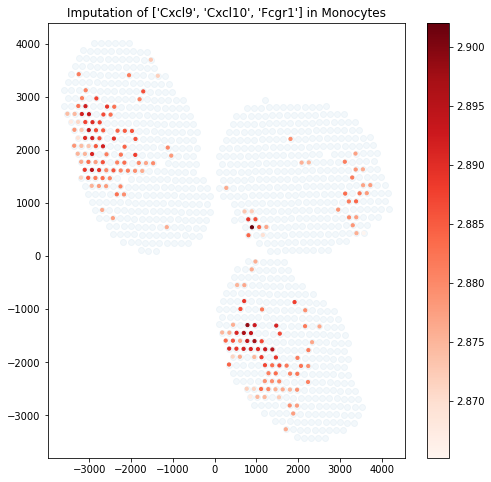

In [ ]:
plt.figure(figsize=(8, 8))

ct_name = "Monocytes"
gene_name = ["Cxcl9", "Cxcl10", "Fcgr1"]


# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.03)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(st_adata.obsm["location"][indices][:, 0], st_adata.obsm["location"][indices][:, 1], 
            c=specific_expression, s=10, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()